With a new dataset, only modifying the following shall be sufficient. 
* Import Data
    * directory
    * file name
    * pd.read_csv() if different file type
    * data_name
    * label_name
* Prepare Data
    * In get_train_data function, modify the way binary labels are defined.
    * Number of posts (iterations) in get_word_data based on your interest
* Results
    * Modify the way 'keyword' is used based on your binary labels.

# Import Data

In [3]:
import pandas as pd
from tqdm import tqdm

In [4]:
directory = '/data2/link10/data/yelp/'
file_name = 'df1M.tsv'
raw_df = pd.read_csv(directory + file_name, delimiter = '\t')
# remove rows with missing values
df = raw_df.dropna()
df.head()

,review_id,stars,text
0,xQY8N_XvtGbearJ5X4QryQ,2,"As someone who has worked with many museums, I..."
1,UmFMZ8PyXZTY2QcwzsfQYA,1,I am actually horrified this place is still in...
2,LG2ZaYiOgpr2DK_90pYjNw,5,I love Deagan's. I do. I really do. The atmosp...
3,i6g_oA9Yf9Y31qt0wibXpw,1,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g..."
4,6TdNDKywdbjoTkizeMce8A,4,"Oh happy day, finally have a Canes near my cas..."


In [5]:
data_name = 'text'
label_name = 'stars'

In [6]:
print(
    'There are {} data.'.format(df.shape[0]),
    'Labels are: {}'.format(df[label_name].unique()),
    sep = '\n'
    )
df[label_name].value_counts()

There are 1000000 data.
Labels are: [2 1 5 4 3]


5    449091
4    210363
1    156690
3    104973
2     78883
Name: stars, dtype: int64

# Embedding

In [7]:
# !python -m spacy download en_core_web_lg
import numpy as np
import spacy

In [9]:
# load the language model
nlp = spacy.load('/data2/link10/models/fasttext/en_fasttext_crawl_subword')

In [10]:
with nlp.disable_pipes():
    msg_vectors = np.array([nlp(msg.lower()).vector for msg in tqdm(df[data_name])])
msg_vectors.shape

100%|██████████| 1000000/1000000 [11:05<00:00, 1503.44it/s]


(1000000, 300)

In [11]:
yelp_fasttext_vectors_subword = msg_vectors
%store yelp_fasttext_vectors_subword

Stored 'yelp_fasttext_vectors_subword' (ndarray)


In [8]:
# embedding takes huge amount of time, use stored result
%store -r yelp_fasttext_vectors_subword
msg_vectors = yelp_fasttext_vectors_subword
msg_vectors.shape

(1000000, 300)

# Play with data

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

<AxesSubplot:xlabel='stars', ylabel='count'>

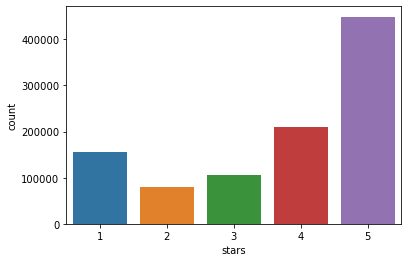

In [10]:
import seaborn as sb
import matplotlib.pyplot as plt
sb.countplot(x = label_name, data=df)

<AxesSubplot:xlabel='stars', ylabel='count'>

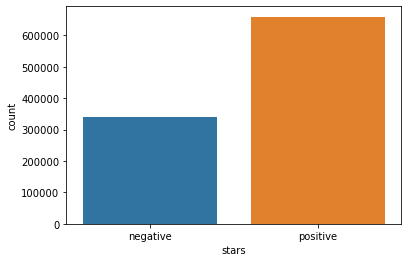

In [11]:
new_df = df.copy()
encode_map = {
    1: 'negative',
    2: 'negative',
    3: 'negative',
    4: 'positive',
    5: 'positive',
}
new_df[label_name].replace(encode_map, inplace=True)
sb.countplot(x = label_name, data=new_df)

In [12]:
# deal with class imbalance

In [13]:
# use partial data set for training
partial = 100000
keyword = 3

In [14]:
labels = np.array([1 if x > keyword else 0 for x in df[label_name]])
X_train, X_test, y_train, y_test = train_test_split(msg_vectors[0:partial], labels[0:partial],
                                                    test_size=0.2, random_state=1)

In [15]:
# # Standardize Input (skip for now)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [16]:
# X_train_ts = torch.from_numpy(X_train).type(torch.FloatTensor)
# Y_train_ts = torch.from_numpy(Y_train).type(torch.LongTensor)
# X_test_ts = torch.from_numpy(X_test).type(torch.FloatTensor)

# Set up Neural Network

In [17]:
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001

In [18]:
## train data
class trainData(Dataset):    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

In [19]:
## test data
class testData(Dataset):    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
test_data = testData(torch.FloatTensor(X_test))

In [20]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)#
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [21]:
# 2 layer Feed-Forward network with BatchNorm and Dropout
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()        # Number of input features is 12.
        self.layer_1 = nn.Linear(300, 1024) 
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_3 = nn.Linear(512, 128)
        self.layer_out = nn.Linear(128, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
#         self.batchnorm1 = nn.BatchNorm1d(512)
#         self.batchnorm2 = nn.BatchNorm1d(512)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
#         x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
#         x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [22]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [23]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=300, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


# Train the model

In [24]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [25]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.36483 | Acc: 83.502
Epoch 002: | Loss: 0.30745 | Acc: 86.946
Epoch 003: | Loss: 0.29720 | Acc: 87.275
Epoch 004: | Loss: 0.28701 | Acc: 87.690
Epoch 005: | Loss: 0.28490 | Acc: 87.834
Epoch 006: | Loss: 0.28324 | Acc: 87.874
Epoch 007: | Loss: 0.27871 | Acc: 88.101
Epoch 008: | Loss: 0.27589 | Acc: 88.157
Epoch 009: | Loss: 0.27372 | Acc: 88.314
Epoch 010: | Loss: 0.27151 | Acc: 88.354


# Test the model

In [26]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [27]:
confusion_matrix(y_test, y_pred_list)

array([[ 5512,  1152],
       [ 1205, 12131]])

In [28]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      6664
           1       0.91      0.91      0.91     13336

    accuracy                           0.88     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.88      0.88      0.88     20000



# Results

In [29]:
def get_word_data(npl,df):
    word_list = []
    word_vec = []
    word_occr_dict = {}
    with nlp.disable_pipes():
        for i in tqdm(range(1000000)):
            msg = nlp(df.iloc[i][data_name].lower())
            for token in msg:
                if token.text not in word_list:
                    word_list.append(token.text)
                    word_vec.append([token.vector])
                    word_occr_dict[token.text] = 1
                else:
                    word_occr_dict[token.text] += 1     
    word_array = np.concatenate(np.array(word_vec),0)
    word_occr = [word_occr_dict[word] for word in word_list]
    return word_list, word_array, word_occr

In [ ]:
# word_list, word_array, word_occr = get_word_data(nlp,df)

In [ ]:
# yelp_fasttext_word_subword = [word_list, word_array, word_occr]
# %store yelp_fasttext_word_subword

In [30]:
# use stored result
%store -r yelp_fasttext_word_subword
word_list = yelp_fasttext_word_subword[0]
word_array = yelp_fasttext_word_subword[1]
word_occr = yelp_fasttext_word_subword[2]

In [31]:
## word data
class wordData(Dataset):    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
word_data = wordData(torch.FloatTensor(word_array))

In [32]:
word_loader = DataLoader(dataset=word_data, batch_size=1)

In [33]:
word_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in tqdm(word_loader):
        X_batch = X_batch.to(device)
        word_pred = model(X_batch)
#         word_pred = torch.sigmoid(word_pred)
        word_pred_list.append(word_pred.cpu().numpy())
word_pred_list = [a.squeeze().tolist() for a in word_pred_list]

100%|██████████| 321423/321423 [02:28<00:00, 2162.18it/s]


In [38]:
top_words = pd.DataFrame({'word':word_list,'pred':word_pred_list,'occurrence':word_occr})
top_words = top_words.sort_values('pred',ascending=False)

In [39]:
thresh = 1000
pos_words_f = top_words[top_words['occurrence']>thresh]

In [40]:
pos_words_f.head(20)

,word,pred,occurrence
7519,joy,79.172264,1754
4707,gem,59.903305,11036
3631,fav,55.360645,2525
4044,ease,54.974483,2953
3046,timely,53.607162,4460
3988,finest,53.021709,1035
313,amazing,51.126606,130807
1896,able,49.089935,39640
1862,pleasure,47.391796,4677
6971,thorough,46.703495,5060


In [42]:
neg_words_f  = pos_words_f.sort_values('pred',ascending=True)
neg_words_f.head(20)

,word,pred,occurrence
4190,scam,-42.290268,2537
7626,lied,-41.502205,2052
1795,rude,-40.556736,30652
3610,rudely,-37.032745,2062
854,waste,-36.723103,11468
4345,ex,-34.227276,1063
2121,sick,-32.755211,6842
721,nor,-32.433567,7077
4366,yelled,-32.409519,1682
4447,filthy,-30.667110,2455


In [1]:
%store

Stored variables and their in-db values:
amazon_fasttext_vectors             -> array([[-0.08999809, -0.09236344, -0.05310385, ...
amazon_fasttext_word                -> [['i', 'have', 'bought', 'several', 'of', 'the', '
amazon_glove_vectors                -> array([[-0.14978772,  0.15294558, -0.09378192, ...
amazon_glove_word                   -> [['i', 'have', 'bought', 'several', 'of', 'the', '
nrc_bert_vectors                    -> array([[  1.3277535 ,  -0.22097862,  12.090231  , 
nrc_bert_word                       -> [['thinks', 'that', '@melbahughes', 'had', 'a', 'g
nrc_fasttext_vectors                -> array([[ 0.01679   , -0.15144   , -0.02061   , ...
nrc_fasttext_word                   -> [['thinks', 'that', '@melbahughes', 'had', 'a', 'g
nrc_glove_vectors                   -> array([[ 0.04746217,  0.181698  ,  0.01058619, ...
nrc_glove_word                      -> [['thinks', 'that', '@melbahughes', 'had', 'a', 'g
yelp_fasttext_vectors               -> array([[-0.03174149,